In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Introducción

En este notebook modelamos la distribución espacial de iones de litio (Li⁺) en las distintas capas de una batería de estado sólido, usando un método Monte Carlo.  
Primero calculamos las concentraciones efectivas de Li⁺ teniendo en cuenta la movilidad en el electrolito sólido (LLZO) y luego simulamos la distribución de partículas en 2D sobre un área transversal de 1 cm².  
Se visualizan las partículas según la proporción molar y el volumen de cada capa.

---

## 1. Cálculo de moles efectivos y concentraciones de Li⁺ por capa


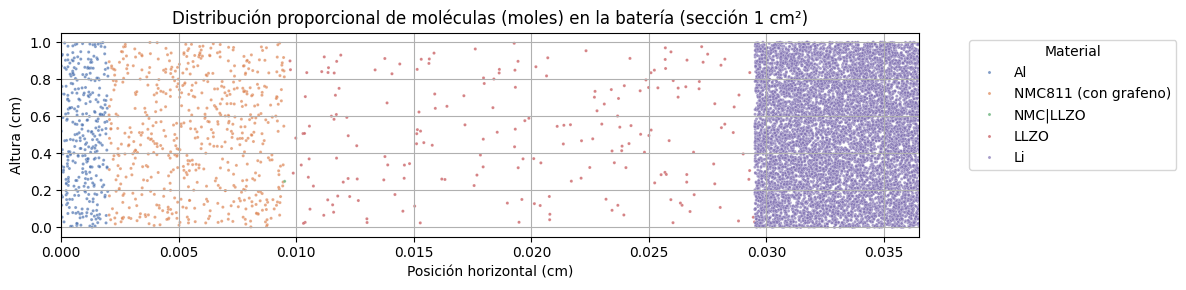

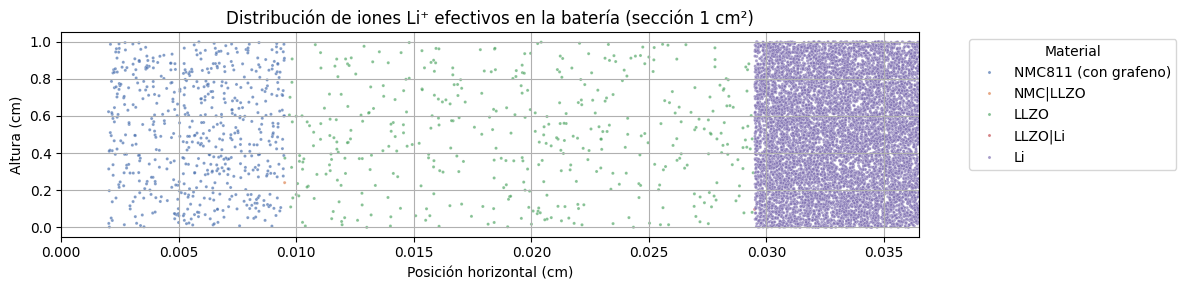

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Paso 1: Leer el archivo CSV con las propiedades de los materiales ---
df = pd.read_csv('1. Generar Datos/material_properties.csv')

# --- Paso 2: Convertir el espesor de metros a centímetros para facilitar la visualización ---
df["Espesor_cm"] = df["Espesor (m)"] * 100

# --- Paso 3: Calcular los bordes acumulados de cada capa para definir rangos en el eje x ---
# Esto permite representar la posición horizontal de cada material en la batería
x_edges = df["Espesor_cm"].cumsum()
x_start = x_edges.shift(fill_value=0)  # inicio de cada capa
x_end = x_edges                      # final de cada capa

# Crear un diccionario con los rangos x para cada material (inicio, fin)
x_ranges = {mat: (start, end) for mat, start, end in zip(df["Material"], x_start, x_end)}

# --- Paso 4: Definir el espesor total de la batería para fijar el rango de las gráficas ---
total_espesor_cm = x_edges.iloc[-1]

# --- Paso 5: Visualización 1 - Distribución proporcional de moléculas (moles) ---
# Calcular la proporción relativa de moles de cada material para determinar el número de partículas a simular
total_moles = df["Moles/m²"].sum()
total_particles = int(1e4)  # Número total de partículas para la visualización

# Calcular el número de partículas por material proporcionalmente a sus moles
df["particles_moles"] = (df["Moles/m²"] / total_moles * total_particles).round().astype(int)

# Función para generar partículas aleatorias dentro del rango horizontal de cada material
def generate_particles(material, count, x_start, x_end):
    x = np.random.uniform(x_start, x_end, count)  # posiciones x dentro del rango del material
    y = np.random.uniform(0, 1, count)            # posiciones y uniformes entre 0 y 1 cm de altura
    return pd.DataFrame({'x': x, 'y': y, 'material': material})

# Generar DataFrames de partículas para cada material según la proporción de moles
dfs_moles = []
for _, row in df.iterrows():
    mat = row["Material"]
    count = row["particles_moles"]
    xs, xe = x_ranges[mat]
    dfs_moles.append(generate_particles(mat, count, xs, xe))

# Concatenar todas las partículas en un único DataFrame para graficar
df_particles_moles = pd.concat(dfs_moles, ignore_index=True)

# Crear gráfica de dispersión con la distribución proporcional a los moles
plt.figure(figsize=(12, 3))
sns.scatterplot(data=df_particles_moles, x='x', y='y', hue='material', s=5, alpha=0.7, palette='deep')
plt.xlim(0, total_espesor_cm)  # Mantener el mismo rango horizontal para comparación visual
plt.xlabel("Posición horizontal (cm)")
plt.ylabel("Altura (cm)")
plt.title("Distribución proporcional de moléculas (moles) en la batería (sección 1 cm²)")
plt.legend(title='Material', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

# --- Paso 6: Visualización 2 - Distribución proporcional de iones Li⁺ efectivos ---
# Filtrar solo los materiales que contienen iones Li⁺ efectivos
df_li = df[df["Li⁺ efectivo/m²"] > 0].copy()

# Calcular total de iones Li⁺ efectivos para la proporción de partículas
total_li = df_li["Li⁺ efectivo/m²"].sum()

# Calcular partículas por material según la proporción de iones Li⁺ efectivos
df_li["particles_li"] = (df_li["Li⁺ efectivo/m²"] / total_li * total_particles).round().astype(int)

# Generar partículas solo para los materiales con iones Li⁺ efectivos
dfs_li = []
for _, row in df_li.iterrows():
    mat = row["Material"]
    count = row["particles_li"]
    xs, xe = x_ranges[mat]  # Utilizamos los mismos rangos que en la primera gráfica para mantener coherencia
    dfs_li.append(generate_particles(mat, count, xs, xe))

df_particles_li = pd.concat(dfs_li, ignore_index=True)

# Crear gráfica de dispersión con distribución de iones Li⁺ efectivos
plt.figure(figsize=(12, 3))
sns.scatterplot(data=df_particles_li, x='x', y='y', hue='material', s=5, alpha=0.7, palette='deep')
plt.xlim(0, total_espesor_cm)  # Mismo rango horizontal para poder comparar con la gráfica anterior
plt.xlabel("Posición horizontal (cm)")
plt.ylabel("Altura (cm)")
plt.title("Distribución de iones Li⁺ efectivos en la batería (sección 1 cm²)")
plt.legend(title='Material', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()
